<a href="https://www.kaggle.com/code/vanpatangan/most-sold-books-in-the-world-eda?scriptVersionId=198626809" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# Loading Dataframe
df = pd.read_csv('/kaggle/input/most-sold-books-in-the-world/Books.csv')

# Data Summary

In [2]:
def check(df):
    """
    Generates a concise summary of DataFrame columns.
    """
    # Use list comprehension to iterate over each column
    summary = [
        [col, df[col].dtype, df[col].count(), df[col].nunique(), df[col].isnull().sum(), df.duplicated().sum()]
        for col in df.columns
    ]

    # Create a DataFrame from the list of lists
    df_check = pd.DataFrame(summary, columns=["column", "dtype", "instances", "unique", "sum_null", "duplicates"])

    return df_check

In [3]:
# Data summary 
check(df)

,column,dtype,instances,unique,sum_null,duplicates
0,Book,object,264,170,0,94
1,Author(s),object,264,153,0,94
2,Original language,object,264,16,0,94
3,First published,object,264,98,0,94
4,Approximate sales,object,264,166,0,94
5,Genre,object,264,74,0,94


In [4]:
df.head()

,Book,Author(s),Original language,First published,Approximate sales,Genre
0,A Tale of Two Cities,Charles Dickens,English,1859,>200 million[20][circular reporting?],Historical fiction
1,The Little Prince (Le Petit Prince),Antoine de Saint-Exupéry,French,1943,200 million[21][22],"Fantasy, Children's fiction"
2,Harry Potter and the Philosopher's Stone,J. K. Rowling,English,1997,120 million[23][24],"Fantasy, Children's fiction"
3,And Then There Were None,Agatha Christie,English,1939,100 million[25],Mystery
4,Dream of the Red Chamber (???),Cao Xueqin,Chinese,1791,100 million[26][27],Family saga


# Visualizations

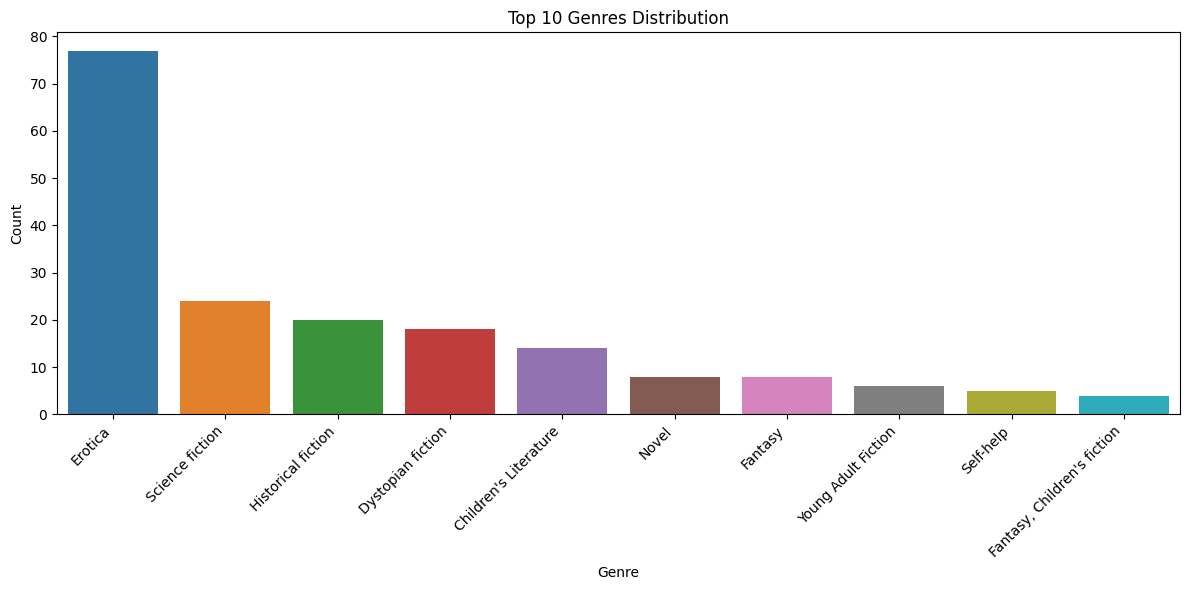

In [5]:
plt.figure(figsize=(12, 6))

# Sort the data by count in descending order and select top 10 genres
top_n = 10  # Change this to show more or fewer genres
genre_counts = df['Genre'].value_counts().nlargest(top_n)

# Create the plot with the sorted data
sns.barplot(x=genre_counts.index, y=genre_counts.values)

plt.title('Top 10 Genres Distribution')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

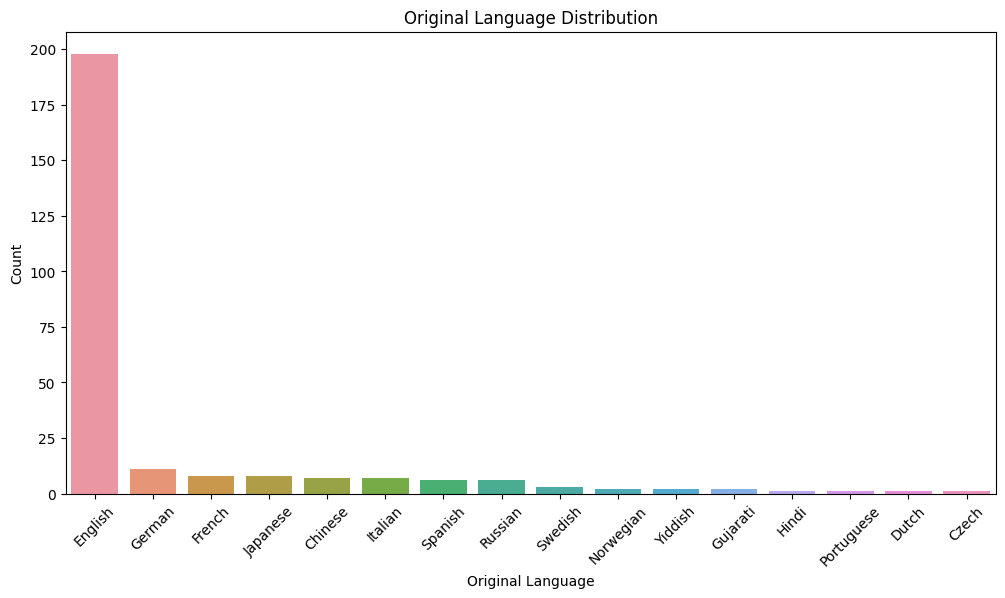

In [6]:
# Chart for original language distribution 

plt.figure(figsize=(12, 6))
sns.countplot(x='Original language', data=df, order=df['Original language'].value_counts().index)
plt.title('Original Language Distribution')
plt.xlabel('Original Language')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


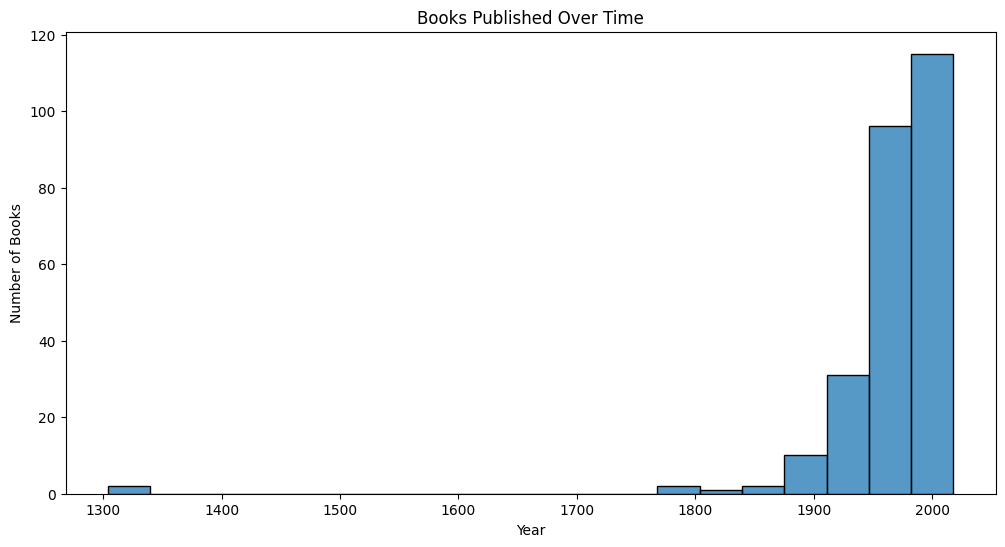

In [7]:
# Yearly Book Publication Trend

df['First published'] = pd.to_numeric(df['First published'], errors='coerce')
plt.figure(figsize=(12, 6))
sns.histplot(df['First published'].dropna(), bins=20)
plt.title('Books Published Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Books')
plt.show()

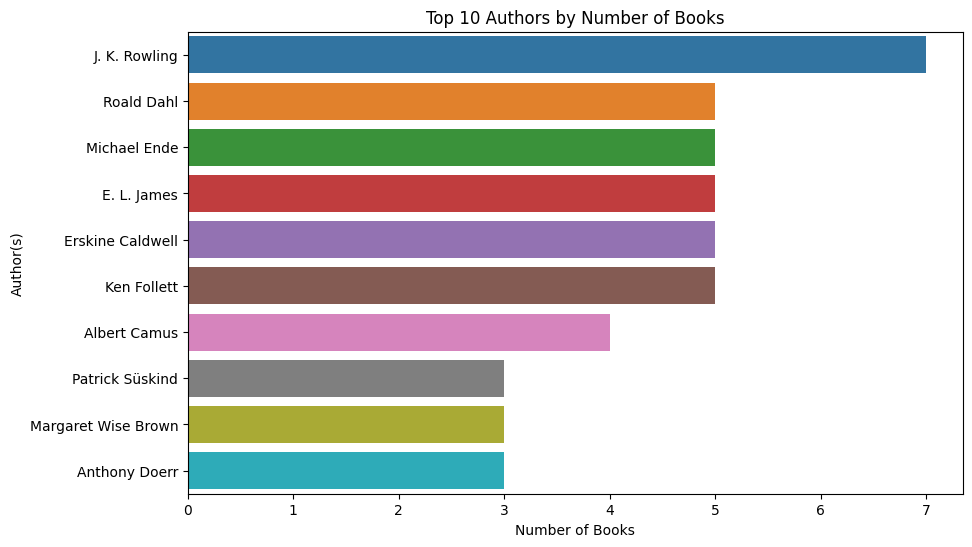

In [8]:
#Top Authors by Number of Books

plt.figure(figsize=(10, 6))
top_authors = df['Author(s)'].value_counts().head(10)
sns.barplot(x=top_authors.values, y=top_authors.index)
plt.title('Top 10 Authors by Number of Books')
plt.xlabel('Number of Books')
plt.ylabel('Author(s)')
plt.show()

# Preprocess and Feature Engineering

In [9]:
# Function to clean sales data
def clean_sales(sales_str):
    # Remove anything in square brackets and non-numeric characters (except for '>' or numbers)
    sales_str = re.sub(r'\[.*?\]', '', sales_str)  # Remove annotations like [20][circular reporting]
    sales_str = re.sub(r'[^\d>]', '', sales_str)   # Keep only numbers and the '>'
    
    # Handle ranges or greater than values
    if '>' in sales_str:
        sales_str = sales_str.replace('>', '')  # Keep the value, drop the '>'
    
    try:
        return float(sales_str)
    except ValueError:
        return None  # Return None for rows that still can't be converted

# Apply the cleaning function
df['Approximate sales'] = df['Approximate sales'].apply(clean_sales)


In [10]:
# Function to extract only the first valid 4-digit year
def extract_first_year(published):
    if pd.isna(published):
        return pd.NA
    
    # Find the first valid 4-digit year (starting with 18, 19, or 20)
    match = re.search(r'\b(18|19|20)\d{2}\b', str(published))
    
    if match:
        # Return the first valid year as a string
        return match.group(0)
    else:
        # Return NaN if no valid year is found
        return pd.NA

# Apply the cleaning function to the 'First published' column
df['First published'] = df['First published'].apply(extract_first_year)

# Convert the cleaned column to integer format
df['First published'] = pd.to_numeric(df['First published'], errors='coerce')

# Drop rows where the year conversion failed (NaN values)
df = df.dropna(subset=['First published'])

In [11]:
# Feature engineering: years since first published
df['Years since published'] = 2024 - df['First published']
df.head()

,Book,Author(s),Original language,First published,Approximate sales,Genre,Years since published
0,A Tale of Two Cities,Charles Dickens,English,1859.0,200.0,Historical fiction,165.0
1,The Little Prince (Le Petit Prince),Antoine de Saint-Exupéry,French,1943.0,200.0,"Fantasy, Children's fiction",81.0
2,Harry Potter and the Philosopher's Stone,J. K. Rowling,English,1997.0,120.0,"Fantasy, Children's fiction",27.0
3,And Then There Were None,Agatha Christie,English,1939.0,100.0,Mystery,85.0
5,The Hobbit,J. R. R. Tolkien,English,1937.0,100.0,"Fantasy, Children's fiction",87.0


# Model and Prediction

In [12]:
# Convert categorical variables to numerical using LabelEncoder
le = LabelEncoder()
df['Author_encoded'] = le.fit_transform(df['Author(s)'])
df['Genre_encoded'] = le.fit_transform(df['Genre'])
df['Language_encoded'] = le.fit_transform(df['Original language'])

# Select features for the model
features = ['First published', 'Years since published', 'Author_encoded', 'Genre_encoded', 'Language_encoded']
X = df[features]
y = df['Approximate sales']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [13]:
# Current year (2024) + 2 years
future_year = 2026

# Create a DataFrame with all books and their future 'Years since published'
future_df = df.copy()
future_df['Years since published'] = future_year - future_df['First published']

# Select features for prediction
future_X = future_df[features]

# Predict future sales
future_sales = model.predict(future_X)

# Add predictions to the DataFrame
future_df['Predicted_Sales'] = future_sales

# Sort by predicted sales and get the top book
top_book = future_df.sort_values('Predicted_Sales', ascending=False).iloc[0]

In [14]:
# Print the result using an f-string
print(f"""Based on this model, the book predicted to be the most sold in the next 2 years is:
Title: "{top_book['Book']}"
Author: "{top_book['Author(s)']}"
Genre: "{top_book['Genre']}"
Predicted Sales: {top_book['Predicted_Sales']:.0f} copies""")

Based on this model, the book predicted to be the most sold in the next 2 years is:
Title: "Bridget Jones's Diary"
Author: "Helen Fielding"
Genre: "Erotica"
Predicted Sales: 47952 copies
